In [2]:
from hockey_rink import NHLRink, RinkImage
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.formula.api as smf
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import math

In [3]:
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows',None)

In [4]:
#load in rink image and data
img = mpimg.imread(r'C:\Users\kjcs2\GitHub\hockey\hockey_env\rink_template.png')
event_data = pd.read_csv("DA_Tutorial24_Event_Data.csv")
ovi_data = event_data
xG_data = pd.read_csv("DA_Tutorial24_xG_Data.csv")


In [5]:
#explore event_data df
event_data.describe()

,compiledgametime,goal,teamid,playerid,opposingteamgoalieoniceid,xadjcoord,yadjcoord
count,1797.000000,1797.000000,1797.000000,1.797000e+03,1797.000000,1797.000000,1797.000000
mean,1898.000296,0.003895,312.994435,9.606105e+05,42812.496383,5.441790,1.937969
std,1114.682648,0.062309,2.000549,3.974927e+06,37566.308585,60.811785,26.349383
min,0.733333,0.000000,311.000000,8.000000e+01,5152.000000,-99.392273,-41.997059
25%,969.266660,0.000000,311.000000,7.862500e+04,5152.000000,-50.104050,-22.382353
50%,1872.600000,0.000000,311.000000,9.453100e+04,80264.000000,28.865601,3.267647
75%,2831.466600,0.000000,315.000000,1.267230e+05,80264.000000,57.525368,26.905884
max,3838.766600,1.000000,315.000000,2.077537e+07,80264.000000,99.392273,41.997059


In [6]:
#convert the compiled game time from seconds into minutes and periods for easier interpretation
event_data['minutes'] = round(event_data['compiledgametime']/60,2)
event_data['period'] = np.where(event_data['minutes'] <= 20, 1, np.where(event_data['minutes'] <=40, 2, np.where(event_data['minutes'] <=60, 3, 4)))


In [7]:
#unfolding the event coordinates to fill the enitre rink

def reverse_adjust_coordinates(row):
    x_adjusted = row['xadjcoord']
    y_adjusted = row['yadjcoord']
    
    team_id = row['teamid']  # Team ID
    period = row['period']    # Period
    
    if team_id == 311: #defend left side twice
        if period in [1,3]: 
            if x_adjusted < 0:
                original_x= x_adjusted #if adjusted is already negative, use it
                original_y = y_adjusted
            else:
                original_x = -x_adjusted #if adjusted is positive, make it negative
                original_y = y_adjusted
        else: #2nd period or OT
            if x_adjusted <0:
                original_x = abs(x_adjusted) #if adjusted is negative, make it positive
                original_y = y_adjusted
            else:
                original_x = x_adjusted #if adjusted is already positive, use it
                original_y = y_adjusted
            
    elif team_id == 315: #defend right side twice
        if period in [1,3]:
            if x_adjusted < 0:
                original_x = abs(x_adjusted) #if adjusted is negative, make it positive
                original_y = abs(y_adjusted)
            else:
                original_x = x_adjusted #if adjusted is positive, use it
                original_y = y_adjusted
        else:#2nd period and OT
            if x_adjusted <0:
                original_x = x_adjusted #if adjusted is negative, use it
                original_y = y_adjusted
            else:
                original_x = -x_adjusted #if adjusted is positive , make it negative
                original_y = y_adjusted
    
    return pd.Series({'xCoord': original_x, 'yCoord': original_y})


original_coords = event_data.apply(reverse_adjust_coordinates, axis=1)


event_data = event_data.join(original_coords)


In [8]:
#creating a shots dataset
shots_data = event_data.query('eventname == "shot" and period == 1')
shots_data = shots_data[['eventname', 'period','teamid','type', 'playsection', 'zone', 'xCoord', 'yCoord','xadjcoord','yadjcoord']]

Question 1, part A, B, C, D

In [9]:
#Looking at all of the goals scored, it appears that the game went into overtime
score = event_data.query('goal ==1')
score

,eventname,outcome,type,compiledgametime,playsection,zone,manpowersituation,goal,teamid,playerid,opposingteamgoalieoniceid,xadjcoord,yadjcoord,minutes,period,xCoord,yCoord
20,shot,successful,outside,38.633335,outsideNorthWest,oz,evenStrength,1,311,109964,80264,80.157722,-13.326469,0.64,1,-80.157722,-13.326469
309,shot,successful,slot,645.066650,eastOuterSlot,oz,evenStrength,1,315,79380,5152,65.687363,21.373528,10.75,1,65.687363,21.373528
805,shot,successful,outside,1676.600000,centerPoint,oz,powerPlay,1,315,79380,5152,46.971462,10.814705,27.94,2,-46.971462,10.814705
1132,shot,successful,slot,2365.633300,innerSlot,oz,evenStrength,1,311,370192,80264,77.262863,-1.258823,39.43,2,77.262863,-1.258823
1203,shot,successful,slot,2504.266600,westOuterSlot,oz,powerPlay,1,311,370192,80264,68.087128,-12.823528,41.74,3,-68.087128,-12.823528
1271,shot,successful,outside,2648.433300,outsideNorthWest,oz,evenStrength,1,315,81408,5152,87.313828,-8.299999,44.14,3,87.313828,-8.299999
1796,shot,successful,outside,3838.766600,outsideNorthWest,oz,powerPlay,1,315,81408,5152,62.562599,-25.900000,63.98,4,-62.562599,-25.900000


In [10]:
#What was the final score
score = score.groupby('teamid')['goal'].count()
score

teamid
311    3
315    4
Name: goal, dtype: int64

In [11]:
#closer investigation into overtime, player who scored the game winning goal is 81408 (Question 2, part A)
overtime = event_data.query('period == 4')
overtime

,eventname,outcome,type,compiledgametime,playsection,zone,manpowersituation,goal,teamid,playerid,opposingteamgoalieoniceid,xadjcoord,yadjcoord,minutes,period,xCoord,yCoord
1669,pass,successful,south,3602.6000,southCenterNZ,nz,evenStrength,0,315,80518,5152,-1.318748,-2.764706,60.04,4,-1.318748,-2.764706
1670,reception,successful,regular,3603.4000,centerPointDZ,dz,evenStrength,0,315,79380,5152,-33.506989,13.329412,60.06,4,-33.506989,13.329412
1671,pass,successful,d2doffboards,3610.8000,outsideNorthWestDZ,dz,evenStrength,0,315,79380,5152,-72.736404,40.488235,60.18,4,-72.736404,40.488235
1672,reception,successful,regular,3612.6000,outsideNorthWestDZ,dz,evenStrength,0,315,80518,5152,-98.386398,6.791176,60.21,4,-98.386398,6.791176
1673,pass,successful,stretchoffboards,3614.5334,outsideNorthWestDZ,dz,evenStrength,0,315,80518,5152,-85.812866,17.352942,60.24,4,-85.812866,17.352942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,pass,successful,south,3835.4000,eastPoint,oz,powerPlay,0,315,126723,5152,51.497932,40.488235,63.92,4,-51.497932,40.488235
1793,reception,successful,regular,3836.2666,centerPoint,oz,powerPlay,0,315,20775372,5152,32.386169,5.785294,63.94,4,-32.386169,5.785294
1794,pass,successful,north,3837.9666,centerPoint,oz,powerPlay,0,315,20775372,5152,33.392052,-7.794117,63.97,4,-33.392052,-7.794117
1795,reception,successful,regular,3838.7334,outsideNorthWest,oz,powerPlay,0,315,81408,5152,62.051838,-26.402939,63.98,4,-62.051838,-26.402939


In [12]:
#blocked shots in overtime Question 1 part D
ot_blocked = overtime[overtime['type'].str.contains('blocked')]
ot_blocked_shots = ot_blocked.query('eventname == "shot"')
# Count occurrences of 'pass' in the 'action' column of the filtered DataFrame
#blocked_shots = (ot_blocked['eventname'] == 'shot').count()
#blocked_shots
ot_blocked_shots.head()

,eventname,outcome,type,compiledgametime,playsection,zone,manpowersituation,goal,teamid,playerid,opposingteamgoalieoniceid,xadjcoord,yadjcoord,minutes,period,xCoord,yCoord
1751,shot,failed,outsideblocked,3742.1000,westPoint,oz,powerPlay,0,315,81408,5152,38.924404,-35.958824,62.37,4,-38.924404,-35.958824
1781,shot,failed,slotblocked,3821.4333,westOuterSlot,oz,powerPlay,0,315,81408,5152,60.550873,-21.876472,63.69,4,-60.550873,-21.876472
1788,shot,failed,slotblocked,3829.3000,westOuterSlot,oz,powerPlay,0,315,81408,5152,59.544991,-20.367645,63.82,4,-59.544991,-20.367645


Question 1, part E: Create a scatter plot for all of the winning team's shot attempts limited to the period answered in c) and highlight the winning goal in a different colour.

(-42.5, 42.5)

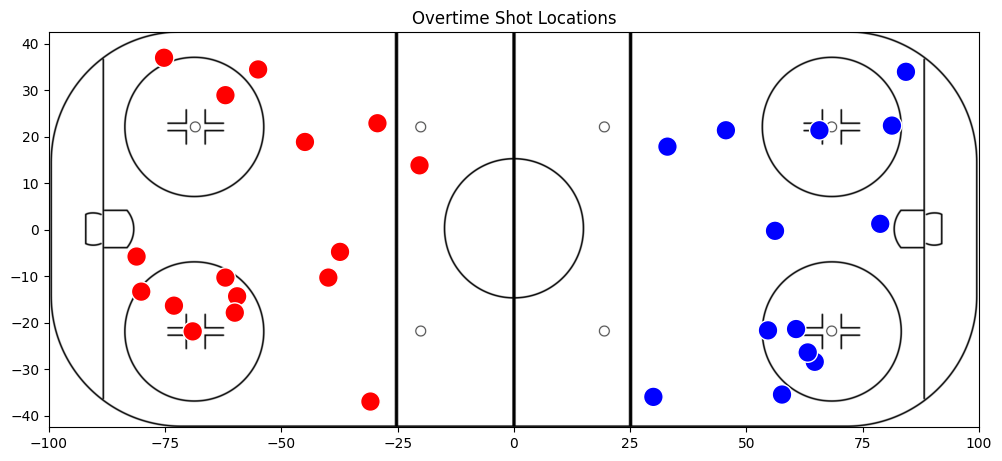

In [13]:
#plotting all of the data onto the rink first
fig, ax = plt.subplots(figsize=(12, 8))


ax.imshow(img, extent=[-100, 100, -42.5, 42.5])  


shots_data.loc[:, 'color'] = 'blue'  
shots_data.loc[shots_data['teamid'] == 311, 'color'] = 'red'

#plot the data points
ax.scatter(shots_data['xCoord'], shots_data['yCoord'],
           s=200, c=shots_data['color'], edgecolor="white")

# Set title
ax.set_title(f"Overtime Shot Locations")

# Set limits to match your data's coordinate system
ax.set_xlim(-100, 100)
ax.set_ylim(-42.5, 42.5)

In [14]:
#identifying the winning team shots in overtime and the goal is scored last
winning_team_shots = overtime.query('teamid == 315 and eventname == "shot"')
winning_team_shots = winning_team_shots[['goal', 'xCoord', 'yCoord' ]]
winning_team_shots

,goal,xCoord,yCoord
1681,0,-60.543015,-21.373528
1690,0,-61.548901,-21.879400
1709,0,-56.527344,7.294117
1714,0,-64.574402,15.341177
1725,0,-59.042049,-19.864708
1730,0,-61.053814,-27.911766
1751,0,-38.924404,-35.958824
1781,0,-60.550873,-21.876472
1788,0,-59.544991,-20.367645
1796,1,-62.562599,-25.900000


(-42.5, 42.5)

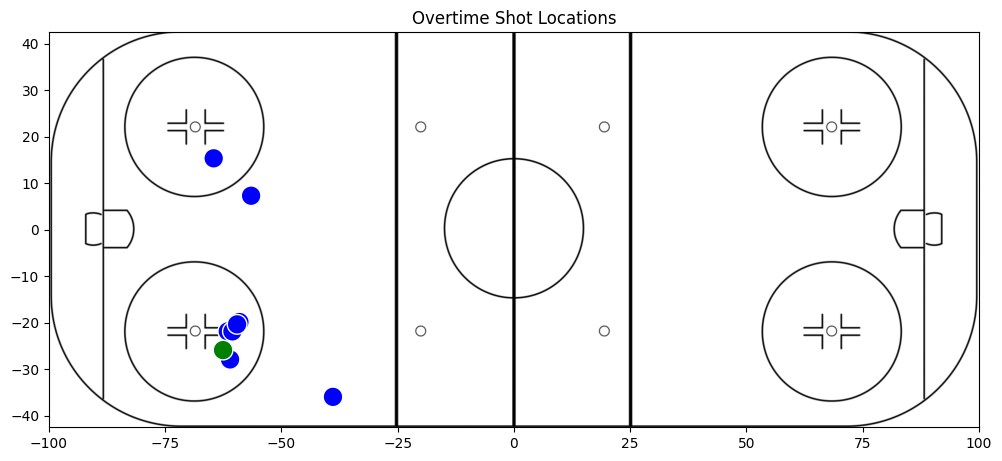

In [15]:
#OT Shot Locations by the winning team with the winning goal in green - QUestion 1 part E

fig, ax = plt.subplots(figsize=(12, 8))


ax.imshow(img, extent=[-100, 100, -42.5, 42.5])  


winning_team_shots['color'] = 'blue'  
winning_team_shots.loc[winning_team_shots['goal'] == 1, 'color'] = 'green'  


ax.scatter(winning_team_shots['xCoord'], winning_team_shots['yCoord'],
           s=200, c=winning_team_shots['color'], edgecolor="white")


ax.set_title(f"Overtime Shot Locations")

ax.set_xlim(-100, 100)
ax.set_ylim(-42.5, 42.5)


Question 2, player id 81408

In [16]:
player_81408 = event_data.query('playerid == 81408')
player_81408.head()

,eventname,outcome,type,compiledgametime,playsection,zone,manpowersituation,goal,teamid,playerid,opposingteamgoalieoniceid,xadjcoord,yadjcoord,minutes,period,xCoord,yCoord
11,reception,successful,regular,19.00000,southWestBoardsNZ,nz,evenStrength,0,315,81408,5152,-15.789108,-36.464706,0.32,1,15.789108,36.464706
55,pass,successful,northoffboards,141.96666,outsideNorthEast,oz,evenStrength,0,315,81408,5152,95.863831,20.870590,2.37,1,95.863831,20.870590
76,reception,successful,regular,171.30000,northEastBoardsNZ,nz,evenStrength,0,315,81408,5152,16.902069,34.952942,2.86,1,16.902069,34.952942
77,pass,successful,rush,171.96666,eastPoint,oz,evenStrength,0,315,81408,5152,34.505005,35.958824,2.87,1,34.505005,35.958824
110,reception,successful,regular,236.90000,outsideNorthWest,oz,powerPlay,0,315,81408,5152,59.659927,-24.394117,3.95,1,59.659927,-24.394117


Question 2, part B shot attempts

In [17]:
shot_attempts = player_81408.query('eventname == "shot"')
pp_shot_attempts = shot_attempts.groupby('manpowersituation')['eventname'].count()
pp_shot_attempts

manpowersituation
evenStrength     2
powerPlay       15
Name: eventname, dtype: int64

In [18]:
#power play shot attempts
pp_attempts = shot_attempts.query('manpowersituation == "powerPlay"')
pp_attempts = pp_attempts[['xCoord', 'yCoord', 'xadjcoord', 'yadjcoord','period', 'teamid' ]]

In [19]:
pp_attempts.head()

,xCoord,yCoord,xadjcoord,yadjcoord,period,teamid
111,60.665802,-21.376471,60.665802,-21.376471,1,315
138,57.640305,-35.458824,57.640305,-35.458824,1,315
411,54.630508,-21.657959,54.630508,-21.657959,1,315
458,63.172653,-26.405882,63.172653,-26.405882,1,315
832,-68.597931,-19.864708,68.597931,-19.864708,2,315


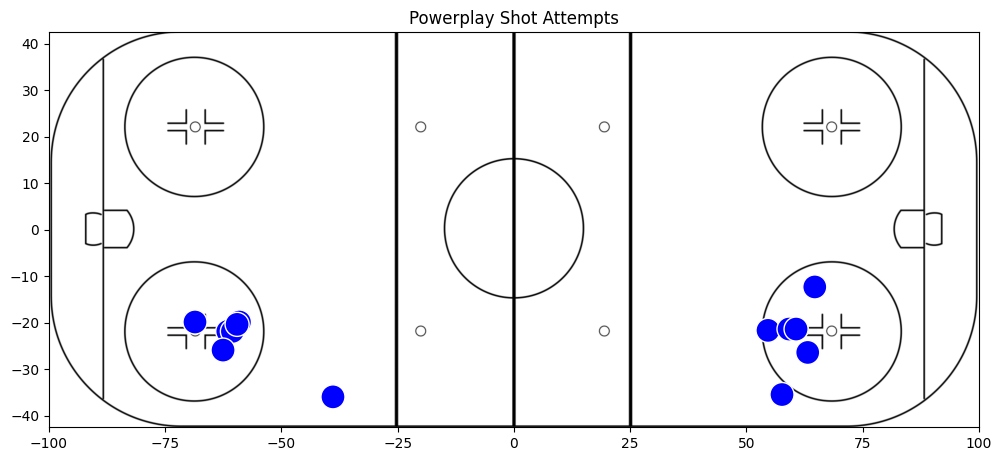

In [20]:
#Power Play shot attempts for the full game

fig, ax = plt.subplots(figsize=(12, 8))

ax.imshow(img, extent=[-100, 100, -42.5, 42.5]) 

pp_attempts['color'] = 'blue' 

ax.scatter(pp_attempts['xCoord'], pp_attempts['yCoord'],
           s=300, c=pp_attempts['color'], edgecolor="white")


# Set limits to match your data's coordinate system
ax.set_xlim(-100, 100)
ax.set_ylim(-42.5, 42.5)
ax.set_title(f"Powerplay Shot Attempts")

plt.show()



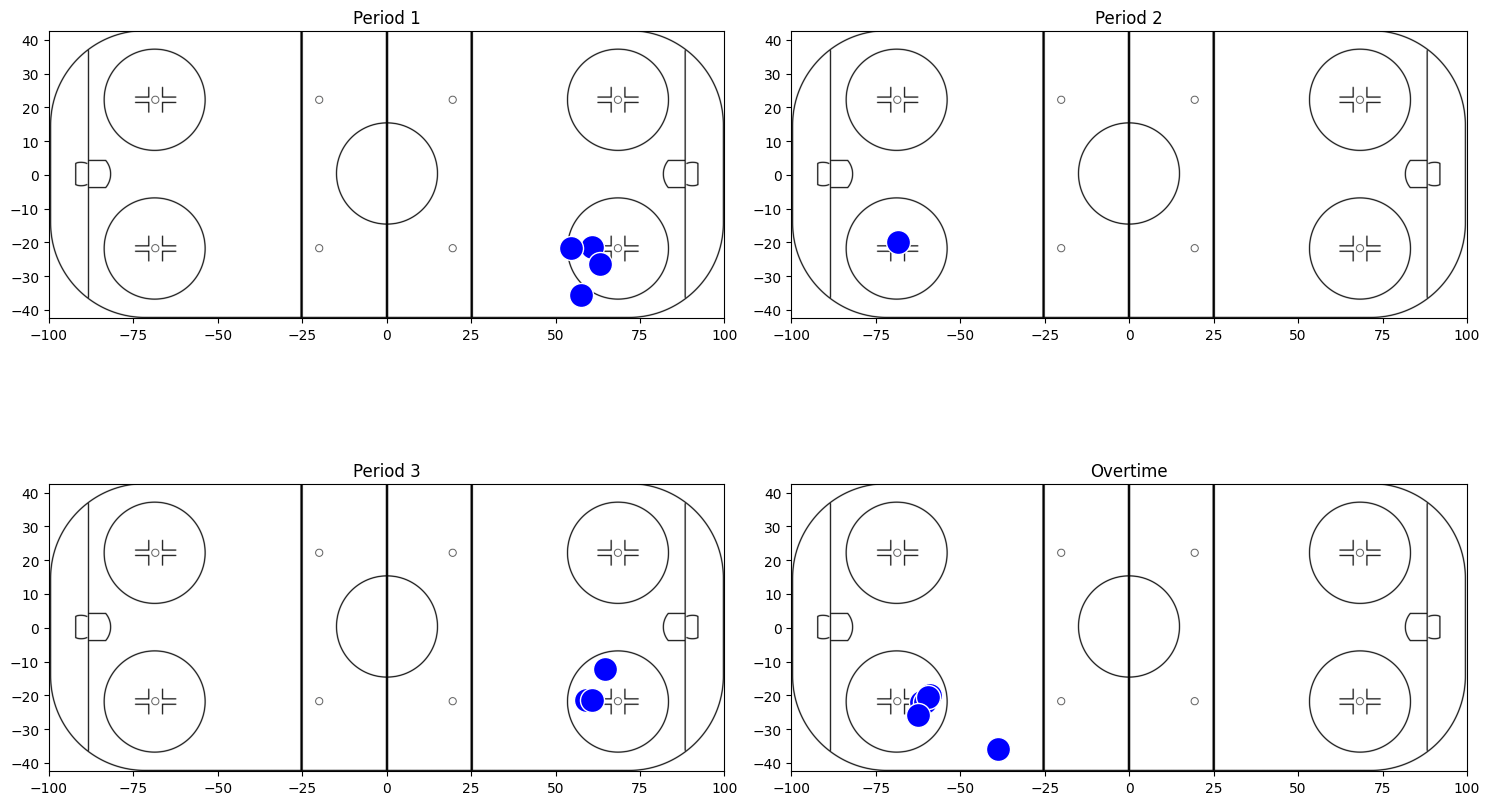

In [21]:
#Power play shot attempts by period
fig, axs = plt.subplots(2, 2, figsize=(15, 10))  


periods = [1, 2, 3, 4]
titles = ["Period 1", "Period 2", "Period 3", "Overtime"]

for ax, period, title in zip(axs.flatten(), periods, titles):

    period_data = pp_attempts[pp_attempts['period'] == period]
    

    ax.imshow(img, extent=[-100, 100, -42.5, 42.5])
    

    ax.scatter(period_data['xCoord'], period_data['yCoord'],
               s=300, c='blue', edgecolor="white")
    

    ax.set_xlim(-100, 100)
    ax.set_ylim(-42.5, 42.5)
    ax.set_title(title)

plt.tight_layout() 
plt.show()


In [22]:
pp_attempts.head()

,xCoord,yCoord,xadjcoord,yadjcoord,period,teamid,color
111,60.665802,-21.376471,60.665802,-21.376471,1,315,blue
138,57.640305,-35.458824,57.640305,-35.458824,1,315,blue
411,54.630508,-21.657959,54.630508,-21.657959,1,315,blue
458,63.172653,-26.405882,63.172653,-26.405882,1,315,blue
832,-68.597931,-19.864708,68.597931,-19.864708,2,315,blue


In [23]:
ovi_data.head()

,eventname,outcome,type,compiledgametime,playsection,zone,manpowersituation,goal,teamid,playerid,opposingteamgoalieoniceid,xadjcoord,yadjcoord,minutes,period
0,pass,successful,south,0.733333,southCenterNZ,nz,evenStrength,0,311,111452,80264,-2.316772,9.808823,0.01,1
1,reception,successful,regular,1.333333,centerPointDZ,dz,evenStrength,0,311,80,80264,-26.457947,6.791176,0.02,1
2,pass,successful,stretchoffboards,2.566667,westPointDZ,dz,evenStrength,0,311,80,80264,-30.481476,30.932352,0.04,1
3,reception,successful,regular,3.166667,northEastBoardsNZ,nz,evenStrength,0,311,111452,80264,3.718521,35.458824,0.05,1
4,pass,successful,outlet,5.433333,innerSlotDZ,dz,evenStrength,0,315,80264,5152,-81.171463,3.770588,0.09,1


Q2 part E, recreate the scatter plot with the y coordinates adjusted

In [24]:
#If it is the case that the player is Ovi, to ensure that the y coordinates are properly unfolded beacause his office is the top of the right circle (goalie POV)

def reverse_adjust_coordinates(row):
    x_adjusted = row['xadjcoord']
    y_adjusted = row['yadjcoord']
    
    team_id = row['teamid']  # Team ID
    period = row['period']    # Period
            
    if period in [1,3]:
        if x_adjusted < 0:
            original_x = abs(x_adjusted) #if adjusted is negative, make it positive
            original_y = abs(y_adjusted)
        else:
            original_x = x_adjusted #if adjusted is positive, use it
            original_y = abs(y_adjusted)
    else:#2nd period and OT
        if x_adjusted <0:
            original_x = x_adjusted #if adjusted is negative, use it
            original_y = y_adjusted
        else:
            original_x = -x_adjusted #if adjusted is positive , make it negative
            original_y = y_adjusted
    
    return pd.Series({'ovixCoords': original_x, 'oviyCoords': original_y})

# Example usage with a DataFrame
# Assuming you have a DataFrame `df` with adjusted coordinates and additional columns
original_coords = pp_attempts.apply(reverse_adjust_coordinates, axis=1)

# Merge the original coordinates back to the original DataFrame if needed
ovi_pp = pp_attempts.join(original_coords)


In [25]:
ovi_pp.head()

,xCoord,yCoord,xadjcoord,yadjcoord,period,teamid,color,ovixCoords,oviyCoords
111,60.665802,-21.376471,60.665802,-21.376471,1,315,blue,60.665802,21.376471
138,57.640305,-35.458824,57.640305,-35.458824,1,315,blue,57.640305,35.458824
411,54.630508,-21.657959,54.630508,-21.657959,1,315,blue,54.630508,21.657959
458,63.172653,-26.405882,63.172653,-26.405882,1,315,blue,63.172653,26.405882
832,-68.597931,-19.864708,68.597931,-19.864708,2,315,blue,-68.597931,-19.864708


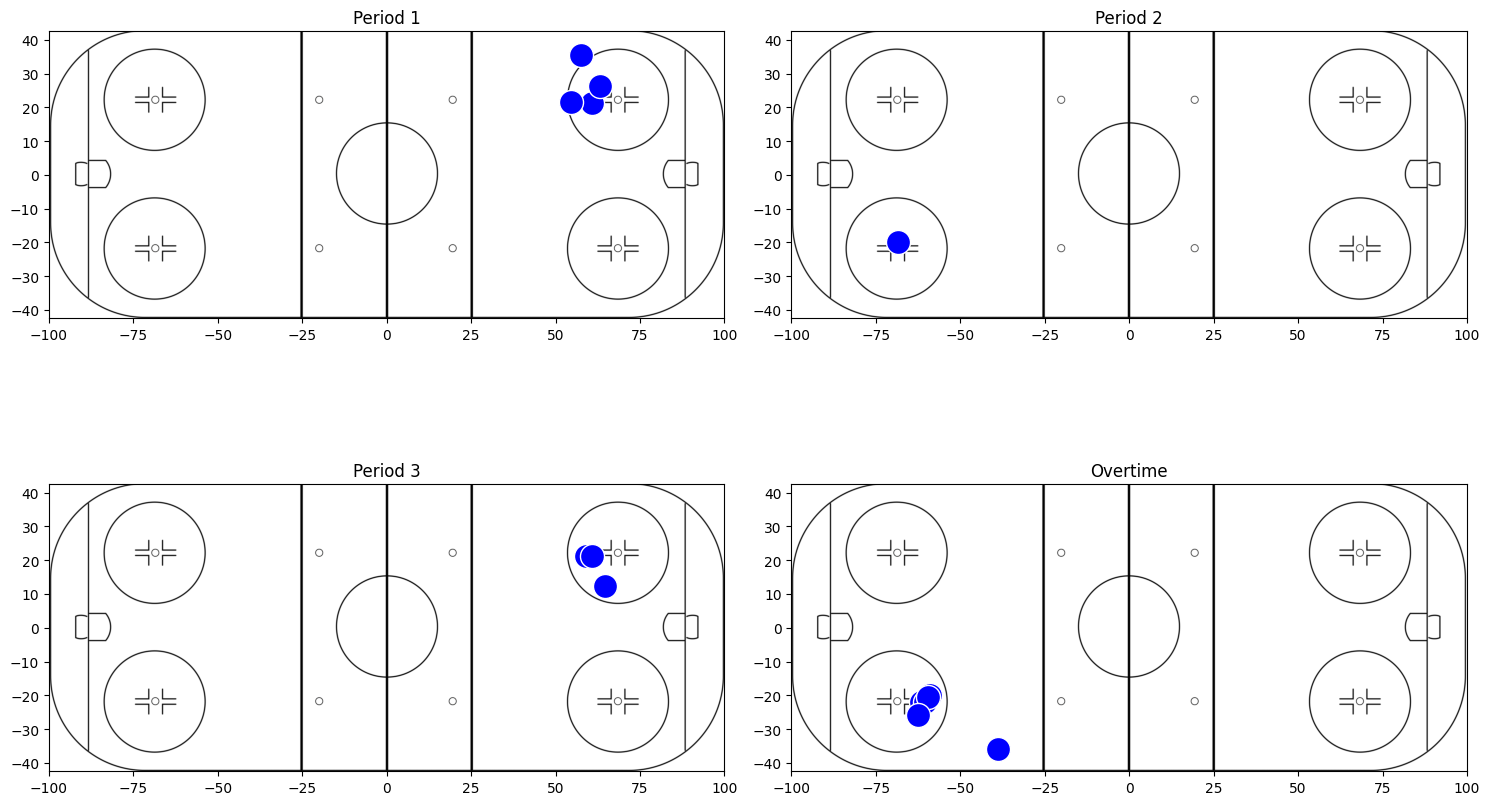

In [26]:

#Updated scatterplot with shots in Ovi's office


fig, axs = plt.subplots(2, 2, figsize=(15, 10)) 


periods = [1, 2, 3, 4]
titles = ["Period 1", "Period 2", "Period 3", "Overtime"]

for ax, period, title in zip(axs.flatten(), periods, titles):

    period_data = ovi_pp[ovi_pp['period'] == period]
    

    ax.imshow(img, extent=[-100, 100, -42.5, 42.5])
    

    ax.scatter(period_data['ovixCoords'], period_data['oviyCoords'],
               s=300, c='blue', edgecolor="white")
    

    ax.set_xlim(-100, 100)
    ax.set_ylim(-42.5, 42.5)
    ax.set_title(title)

plt.tight_layout() 
plt.show()


Question 3, part A - even strength pass completion rate for each team broken down by zone

In [27]:
#team 315 even strength passing
team_315_passes = event_data.query('teamid == 315 and eventname == "pass" and manpowersituation == "evenStrength"')
team_315_passes['success'] = np.where(team_315_passes['outcome'] == "successful", "success", "failed")


team_315_passes=team_315_passes.groupby(['eventname', 'zone','success'])['outcome'].count()

team_315_passes = pd.DataFrame(team_315_passes).reset_index()
team_315_passes.head()

C:\Users\kjcs2\AppData\Local\Temp\ipykernel_22544\2216007909.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_315_passes['success'] = np.where(team_315_passes['outcome'] == "successful", "success", "failed")


,eventname,zone,success,outcome
0,pass,dz,failed,37
1,pass,dz,success,115
2,pass,nz,failed,12
3,pass,nz,success,28
4,pass,oz,failed,40


In [28]:
team_315_passes = team_315_passes.pivot(index='zone', columns='success', values='outcome')
team_315_passes = team_315_passes.fillna(0)

In [29]:

team_315_passes=team_315_passes.reset_index()
team_315_passes

success,zone,failed,success
0,dz,37,115
1,nz,12,28
2,oz,40,43


In [30]:
team_315_passes['total_attempts'] = team_315_passes['failed']+ team_315_passes['success']
team_315_passes['pass_rate'] = team_315_passes['success']/team_315_passes['total_attempts']
team_315_passes['pass_rate_pct'] = round(team_315_passes['pass_rate']*100,2)
team_315_passes

success,zone,failed,success,total_attempts,pass_rate,pass_rate_pct
0,dz,37,115,152,0.756579,75.66
1,nz,12,28,40,0.700000,70.00
2,oz,40,43,83,0.518072,51.81


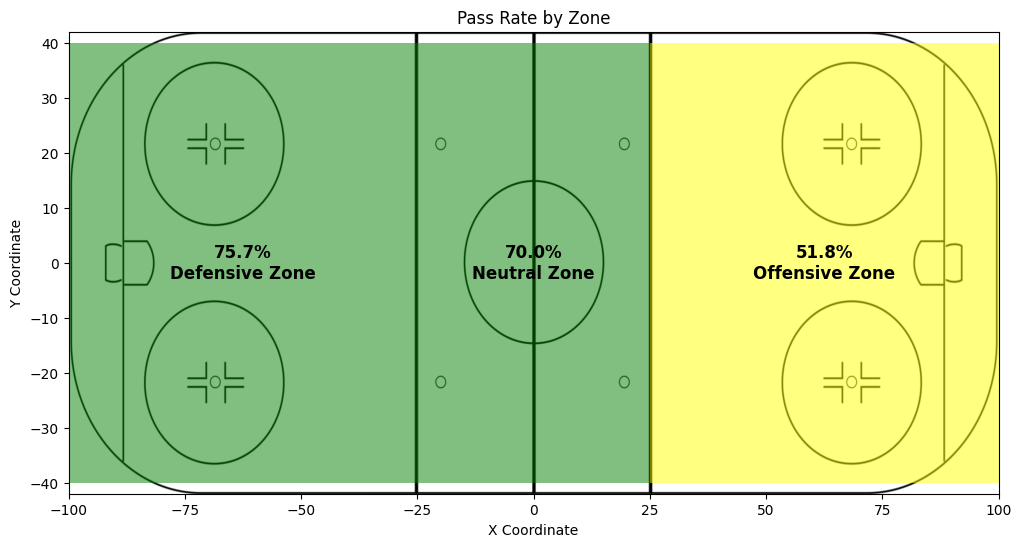

In [31]:
# Load the rink image
img = mpimg.imread(r'C:\Users\kjcs2\GitHub\hockey\hockey_env\rink_template.png')

# Define the extent of the image on the rink
extent = [-100, 100, -42, 42]

# Define zone extents
zone_ranges = {
    'dz': {'x': (-100, -25), 'y': (-40, 40)},
    'nz': {'x': (-25, 25), 'y': (-40, 40)},
    'oz': {'x': (25, 100), 'y': (-40, 40)}
}

zone_names = {
    'dz': 'Defensive Zone',
    'nz': 'Neutral Zone',
    'oz': 'Offensive Zone'
}


# Define the colormap and boundaries
cmap = ListedColormap(['red', 'yellow', 'green'])
bounds = [0, .45, .60, 1.00]
norm = BoundaryNorm(bounds, cmap.N)


# Create a blank image to overlay heatmaps
fig, ax = plt.subplots(figsize=(12, 6))

# Display the rink image
ax.imshow(img, extent=extent, aspect='auto')

# Plot heatmaps for each zone
# Plot background color rectangles for each zone based on pass rate
for _, row in team_315_passes.iterrows():
    zone = row['zone']
    pass_rate_pct = row['pass_rate_pct']
    pass_rate = row['pass_rate']

    # Determine zone extents
    zone_extent = zone_ranges[zone]

    # Create a masked array for background color
    gradient = np.full((2, 256), pass_rate)
    im = ax.imshow(gradient, aspect='auto', cmap=cmap, norm=norm,
                   extent=[zone_extent['x'][0], zone_extent['x'][1],
                           zone_extent['y'][0], zone_extent['y'][1]],
                   alpha=0.5)

    # Annotate the pass rate in the zone
    cx = (zone_extent['x'][0] + zone_extent['x'][1]) / 2
    cy = (zone_extent['y'][0] + zone_extent['y'][1]) / 2
    zone_full_name = zone_names[zone]  # Get the full zone name
    ax.text(cx, cy, f'{pass_rate_pct:.1f}%\n{zone_full_name}', 
            color='black', ha='center', va='center', 
            fontsize=12, fontweight='bold')
# Set limits and labels
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])
ax.set_title('Pass Rate by Zone')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')

plt.show()


In [32]:
#team 311 even strength passing
team_311_passes = event_data.query('teamid == 311 and eventname == "pass" and manpowersituation == "evenStrength"')
team_311_passes['success'] = np.where(team_311_passes['outcome'] == "successful", "success", "failed")


team_311_passes=team_311_passes.groupby(['eventname', 'zone','success'])['outcome'].count()

team_311_passes = pd.DataFrame(team_311_passes).reset_index()

team_311_passes = team_311_passes.pivot(index='zone', columns='success', values='outcome')
team_311_passes = team_311_passes.fillna(0)

C:\Users\kjcs2\AppData\Local\Temp\ipykernel_22544\3507012032.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_311_passes['success'] = np.where(team_311_passes['outcome'] == "successful", "success", "failed")


In [33]:
team_311_passes=team_311_passes.reset_index()
team_311_passes['total_attempts'] = team_311_passes['failed']+ team_311_passes['success']
team_311_passes['pass_rate'] = team_311_passes['success']/team_311_passes['total_attempts']
team_311_passes['pass_rate_pct'] = round(team_311_passes['pass_rate']*100,2)

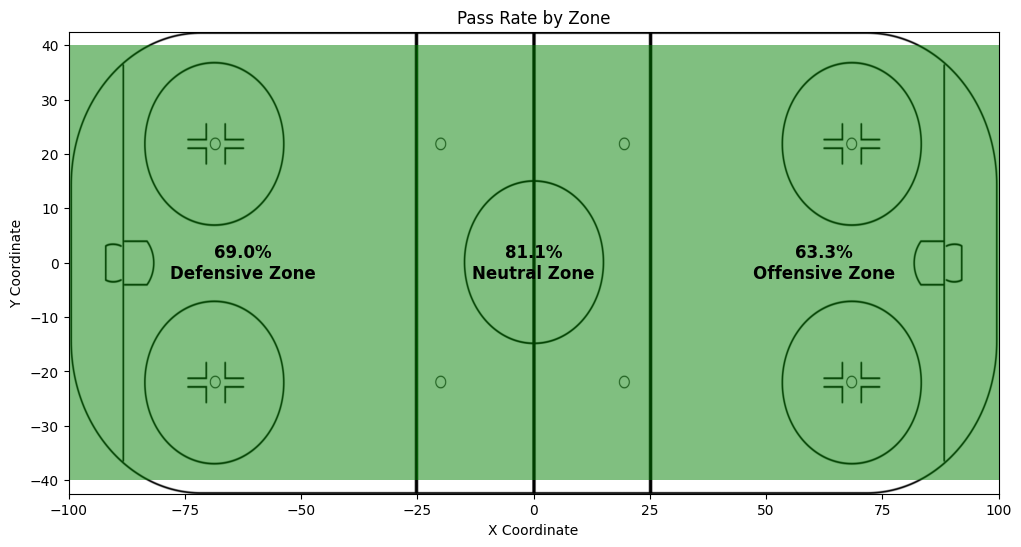

In [34]:
# Load the rink image
img = mpimg.imread(r'C:\Users\kjcs2\GitHub\hockey\hockey_env\rink_template.png')

# Define the extent of the image on the rink
extent = [-100, 100, -42.5, 42.5]

# Define zone extents
zone_ranges = {
    'dz': {'x': (-100, -25), 'y': (-40, 40)},
    'nz': {'x': (-25, 25), 'y': (-40, 40)},
    'oz': {'x': (25, 100), 'y': (-40, 40)}
}

zone_names = {
    'dz': 'Defensive Zone',
    'nz': 'Neutral Zone',
    'oz': 'Offensive Zone'
}


# Define the colormap and boundaries
cmap = ListedColormap(['red', 'yellow', 'green'])
bounds = [0, .45, .60, 1.00]
norm = BoundaryNorm(bounds, cmap.N)


# Create a blank image to overlay heatmaps
fig, ax = plt.subplots(figsize=(12, 6))

# Display the rink image
ax.imshow(img, extent=extent, aspect='auto')

# Plot heatmaps for each zone
# Plot background color rectangles for each zone based on pass rate
for _, row in team_311_passes.iterrows():
    zone = row['zone']
    pass_rate_pct = row['pass_rate_pct']
    pass_rate = row['pass_rate']

    # Determine zone extents
    zone_extent = zone_ranges[zone]

    # Create a masked array for background color
    gradient = np.full((2, 256), pass_rate)
    im = ax.imshow(gradient, aspect='auto', cmap=cmap, norm=norm,
                   extent=[zone_extent['x'][0], zone_extent['x'][1],
                           zone_extent['y'][0], zone_extent['y'][1]],
                   alpha=0.5)

    # Annotate the pass rate in the zone
    cx = (zone_extent['x'][0] + zone_extent['x'][1]) / 2
    cy = (zone_extent['y'][0] + zone_extent['y'][1]) / 2
    zone_full_name = zone_names[zone]  # Get the full zone name
    ax.text(cx, cy, f'{pass_rate_pct:.1f}%\n{zone_full_name}', 
            color='black', ha='center', va='center', 
            fontsize=12, fontweight='bold')
# Set limits and labels
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])
ax.set_title('Pass Rate by Zone')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')

plt.show()


In [35]:
event_data.head()

,eventname,outcome,type,compiledgametime,playsection,zone,manpowersituation,goal,teamid,playerid,opposingteamgoalieoniceid,xadjcoord,yadjcoord,minutes,period,xCoord,yCoord
0,pass,successful,south,0.733333,southCenterNZ,nz,evenStrength,0,311,111452,80264,-2.316772,9.808823,0.01,1,-2.316772,9.808823
1,reception,successful,regular,1.333333,centerPointDZ,dz,evenStrength,0,311,80,80264,-26.457947,6.791176,0.02,1,-26.457947,6.791176
2,pass,successful,stretchoffboards,2.566667,westPointDZ,dz,evenStrength,0,311,80,80264,-30.481476,30.932352,0.04,1,-30.481476,30.932352
3,reception,successful,regular,3.166667,northEastBoardsNZ,nz,evenStrength,0,311,111452,80264,3.718521,35.458824,0.05,1,-3.718521,35.458824
4,pass,successful,outlet,5.433333,innerSlotDZ,dz,evenStrength,0,315,80264,5152,-81.171463,3.770588,0.09,1,81.171463,3.770588


Question 3, part D slot save percentage

In [36]:
#teamid 311's all strengths slot save percentage?

team_311_saves = event_data.query('teamid == 311 and eventname == "shot" or eventname == "pass"')

team_311_saves = team_311_saves[team_311_saves['playsection'].str.contains('Slot')]
#team_311_saves = team_311_saves[team_311_saves['type'].str.contains('blocked')]
team_311_saves

,eventname,outcome,type,compiledgametime,playsection,zone,manpowersituation,goal,teamid,playerid,opposingteamgoalieoniceid,xadjcoord,yadjcoord,minutes,period,xCoord,yCoord
4,pass,successful,outlet,5.433333,innerSlotDZ,dz,evenStrength,0,315,80264,5152,-81.171463,3.770588,0.09,1,81.171463,3.770588
65,pass,successful,outlet,154.100000,westOuterSlotDZ,dz,evenStrength,0,311,80,80264,-54.622650,4.779411,2.57,1,-54.622650,4.779411
73,pass,successful,d2d,168.700000,eastOuterSlotDZ,dz,evenStrength,0,315,20775372,5152,-58.036167,-18.358824,2.81,1,58.036167,18.358824
75,pass,successful,stretch,170.366670,westOuterSlotDZ,dz,evenStrength,0,315,20161,5152,-57.533226,19.864708,2.84,1,57.533226,19.864708
91,pass,successful,outlet,201.066670,westOuterSlotDZ,dz,powerPlay,0,315,79380,5152,-57.525368,17.349998,3.35,1,57.525368,17.349998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1738,pass,successful,outlet,3725.533400,innerSlotDZ,dz,shortHanded,0,311,94531,80264,-79.151840,3.770588,62.09,4,79.151840,3.770588
1740,pass,successful,outlet,3726.333300,innerSlotDZ,dz,shortHanded,0,311,111452,80264,-63.560661,0.250000,62.11,4,63.560661,0.250000
1743,pass,successful,d2d,3731.200000,innerSlotDZ,dz,powerPlay,0,315,81408,5152,-63.675598,0.252941,62.19,4,-63.675598,0.252941
1752,pass,successful,south,3743.566700,westOuterSlot,oz,powerPlay,0,315,10534,5152,73.627342,-12.320587,62.39,4,-73.627342,-12.320587


In [37]:

team_311_saves['success'] = np.where(team_311_saves['outcome'] == "successful", "success", "failed")


team_311_saves=team_311_saves.groupby(['eventname','success'])['outcome'].count()

team_311_saves = pd.DataFrame(team_311_saves).reset_index()
team_311_saves.head()

,eventname,success,outcome
0,pass,failed,17
1,pass,success,63
2,shot,failed,14
3,shot,success,14


In [38]:
team_311_saves = team_311_saves.pivot(index='eventname', columns='success', values='outcome')
team_311_saves = team_311_saves.fillna(0)

In [39]:

team_311_saves=team_311_saves.reset_index()
team_311_saves

success,eventname,failed,success
0,pass,17,63
1,shot,14,14


In [40]:
team_311_saves['total_attempts'] = team_311_saves['failed']+ team_311_saves['success']
team_311_saves['stop_rate'] = team_311_saves['failed']/team_311_saves['total_attempts']
team_311_saves['stop_rate_pct'] = round(team_311_saves['stop_rate']*100,2)
team_311_saves

success,eventname,failed,success,total_attempts,stop_rate,stop_rate_pct
0,pass,17,63,80,0.2125,21.25
1,shot,14,14,28,0.5000,50.00


In [41]:
#315 sog

shots_315 = event_data.query('teamid == 315 and eventname == "shot" and playsection == "outsideNorthWest"')
shots_315 = shots_315[['eventname', 'outcome', 'goal', 'xCoord', 'yCoord']]
shots_315

,eventname,outcome,goal,xCoord,yCoord
138,shot,failed,0,57.640305,-35.458824
405,shot,failed,0,64.681473,-28.417646
458,shot,failed,0,63.172653,-26.405882
1249,shot,successful,0,61.168747,-31.938236
1271,shot,successful,1,87.313828,-8.299999
1730,shot,successful,0,-61.053814,-27.911766
1796,shot,successful,1,-62.562599,-25.900000


Question 4 part A - all strengths average shot distance

In [42]:
#center net
net_x = 89
net_y = 0

def calculate_distance(x, y, net_x=net_x, net_y=net_y):
    return math.sqrt((x - net_x)**2 + (y - net_y)**2)


shots_315['distance'] = shots_315.apply(lambda row: calculate_distance(row['xCoord'], row['yCoord']), axis=1)
shots_315

,eventname,outcome,goal,xCoord,yCoord,distance
138,shot,failed,0,57.640305,-35.458824,47.336653
405,shot,failed,0,64.681473,-28.417646,37.402585
458,shot,failed,0,63.172653,-26.405882,36.936736
1249,shot,successful,0,61.168747,-31.938236,42.363069
1271,shot,successful,1,87.313828,-8.299999,8.469543
1730,shot,successful,0,-61.053814,-27.911766,152.627697
1796,shot,successful,1,-62.562599,-25.900000,153.759655


In [43]:
#all shot attempts
round(shots_315['distance'].mean(),2)

68.41

In [44]:
#all shots on goal
sog_315 = shots_315.query('outcome == "successful"')
round(sog_315['distance'].mean(),2)

89.3

In [45]:
xG_data.head()

,compiledgametime,playerid,xg
0,82.2,56711,0.252678
1,90.9,108339,0.392448
2,154.1,80,0.322435
3,234.5,78625,0.261145
4,236.3,79380,0.252039


Question 4 part B - goals saved above expected

In [46]:
gsaExpected = event_data.query('playsection == "outsideNorthWest"')
gsaExpected = gsaExpected[['eventname','goal', 'playerid', 'compiledgametime','type','teamid']]

In [47]:
gsaExpected

,eventname,goal,playerid,compiledgametime,type,teamid
14,pass,0,109964,29.566668,south,311
18,pass,0,370192,38.033333,south,311
19,reception,0,109964,38.400000,regular,311
20,shot,1,109964,38.633335,outside,311
23,reception,0,126723,50.500000,regular,315
...,...,...,...,...,...,...
1749,pass,0,10534,3740.333300,southoffboards,315
1780,reception,0,81408,3821.400000,regular,315
1782,pass,0,884,3823.533400,northoffboards,315
1795,reception,0,81408,3838.733400,regular,315


In [48]:
expected_goals = pd.merge(gsaExpected, xG_data, on=['compiledgametime', 'playerid'], how='inner')

all_data = pd.merge(gsaExpected, xG_data, on=['compiledgametime', 'playerid'], how='inner')
all_data

,eventname,goal,playerid,compiledgametime,type,teamid,xg
0,shot,1,109964,38.633335,outside,311,0.072824
1,shot,0,81408,306.900000,outsideblocked,315,0.010496
2,pass,0,111452,354.200000,northoffboards,311,0.510810
3,shot,0,400162,881.266660,outsideblocked,315,0.011721
4,shot,0,81408,981.266660,outside,315,0.047728
5,shot,0,111452,1885.233300,outsideblocked,311,0.017890
6,shot,0,94531,2027.233300,outside,311,0.016057
7,shot,0,370192,2125.233400,outside,311,0.032598
8,shot,0,56711,2590.066700,outside,315,0.010988
9,shot,1,81408,2648.433300,outside,315,0.312032


In [49]:
expected_goals

,eventname,goal,playerid,compiledgametime,type,teamid,xg
0,shot,1,109964,38.633335,outside,311,0.072824
1,shot,0,81408,306.900000,outsideblocked,315,0.010496
2,pass,0,111452,354.200000,northoffboards,311,0.510810
3,shot,0,400162,881.266660,outsideblocked,315,0.011721
4,shot,0,81408,981.266660,outside,315,0.047728
5,shot,0,111452,1885.233300,outsideblocked,311,0.017890
6,shot,0,94531,2027.233300,outside,311,0.016057
7,shot,0,370192,2125.233400,outside,311,0.032598
8,shot,0,56711,2590.066700,outside,315,0.010988
9,shot,1,81408,2648.433300,outside,315,0.312032


In [50]:
expected_goals = expected_goals[['goal','xg']]


In [51]:

total_expected  = expected_goals['xg'].sum()
total_allowed = expected_goals['goal'].sum()

GSAx = total_expected-total_allowed
print(total_expected)
print(total_allowed)
print(GSAx)

1.424924397527426
3
-1.575075602472574


Question 5: part A, shot assists

In [52]:
shot_assists = event_data.copy()
#shot_assists= shot_assists.drop(['shot_assist','assisted_shot'], axis=1)
shot_assists

,eventname,outcome,type,compiledgametime,playsection,zone,manpowersituation,goal,teamid,playerid,opposingteamgoalieoniceid,xadjcoord,yadjcoord,minutes,period,xCoord,yCoord
0,pass,successful,south,0.733333,southCenterNZ,nz,evenStrength,0,311,111452,80264,-2.316772,9.808823,0.01,1,-2.316772,9.808823
1,reception,successful,regular,1.333333,centerPointDZ,dz,evenStrength,0,311,80,80264,-26.457947,6.791176,0.02,1,-26.457947,6.791176
2,pass,successful,stretchoffboards,2.566667,westPointDZ,dz,evenStrength,0,311,80,80264,-30.481476,30.932352,0.04,1,-30.481476,30.932352
3,reception,successful,regular,3.166667,northEastBoardsNZ,nz,evenStrength,0,311,111452,80264,3.718521,35.458824,0.05,1,-3.718521,35.458824
4,pass,successful,outlet,5.433333,innerSlotDZ,dz,evenStrength,0,315,80264,5152,-81.171463,3.770588,0.09,1,81.171463,3.770588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,pass,successful,south,3835.400000,eastPoint,oz,powerPlay,0,315,126723,5152,51.497932,40.488235,63.92,4,-51.497932,40.488235
1793,reception,successful,regular,3836.266600,centerPoint,oz,powerPlay,0,315,20775372,5152,32.386169,5.785294,63.94,4,-32.386169,5.785294
1794,pass,successful,north,3837.966600,centerPoint,oz,powerPlay,0,315,20775372,5152,33.392052,-7.794117,63.97,4,-33.392052,-7.794117
1795,reception,successful,regular,3838.733400,outsideNorthWest,oz,powerPlay,0,315,81408,5152,62.051838,-26.402939,63.98,4,-62.051838,-26.402939


In [53]:
shot_assists['shot_assist1'] = False

for idx, row in shot_assists[shot_assists['eventname'] == 'shot'].iterrows():
 
    shot_player = row['playerid']
    shot_period = row['period']
    shot_team = row['teamid']
    

    preceding_events = shot_assists[(shot_assists['period'] == shot_period) & 
                                     (shot_assists['compiledgametime'] < row['compiledgametime'])]
    

    has_shot_assist = False
    for pass_idx, pass_row in preceding_events[preceding_events['eventname'] == 'pass'].iterrows():
        pass_player = pass_row['playerid']

        reception = preceding_events[(preceding_events['eventname'] == 'reception') & 
                                     (preceding_events['teamid'] == shot_team) & 
                                     (preceding_events['playerid'] == pass_row['playerid']) & 
                                     (preceding_events['compiledgametime'] > pass_row['compiledgametime'])]

        if not reception.empty:

            if reception.iloc[0]['playerid'] == pass_player:
                has_shot_assist = True
                break


    shot_assists.at[idx, 'shot_assist1'] = has_shot_assist
shot_assists['shot_assist'] = shot_assists['shot_assist1'].shift(-2)
shot_assists = shot_assists.drop('shot_assist1', axis=1)

In [54]:
shot_assists.head()

,eventname,outcome,type,compiledgametime,playsection,zone,manpowersituation,goal,teamid,playerid,opposingteamgoalieoniceid,xadjcoord,yadjcoord,minutes,period,xCoord,yCoord,shot_assist
0,pass,successful,south,0.733333,southCenterNZ,nz,evenStrength,0,311,111452,80264,-2.316772,9.808823,0.01,1,-2.316772,9.808823,False
1,reception,successful,regular,1.333333,centerPointDZ,dz,evenStrength,0,311,80,80264,-26.457947,6.791176,0.02,1,-26.457947,6.791176,False
2,pass,successful,stretchoffboards,2.566667,westPointDZ,dz,evenStrength,0,311,80,80264,-30.481476,30.932352,0.04,1,-30.481476,30.932352,False
3,reception,successful,regular,3.166667,northEastBoardsNZ,nz,evenStrength,0,311,111452,80264,3.718521,35.458824,0.05,1,-3.718521,35.458824,False
4,pass,successful,outlet,5.433333,innerSlotDZ,dz,evenStrength,0,315,80264,5152,-81.171463,3.770588,0.09,1,81.171463,3.770588,False


In [55]:
player_id = 79380
player_79380=shot_assists[(shot_assists['playerid'] == player_id) & (shot_assists['shot_assist'])].shape[0]
print(f"Shot assists for {player_id}: {player_79380}")

Shot assists for 79380: 16


In [56]:

shot_assists = pd.merge(shot_assists, xG_data, on=['compiledgametime', 'playerid'], how='left')

shot_assists.head()

,eventname,outcome,type,compiledgametime,playsection,zone,manpowersituation,goal,teamid,playerid,opposingteamgoalieoniceid,xadjcoord,yadjcoord,minutes,period,xCoord,yCoord,shot_assist,xg
0,pass,successful,south,0.733333,southCenterNZ,nz,evenStrength,0,311,111452,80264,-2.316772,9.808823,0.01,1,-2.316772,9.808823,False,NaN
1,reception,successful,regular,1.333333,centerPointDZ,dz,evenStrength,0,311,80,80264,-26.457947,6.791176,0.02,1,-26.457947,6.791176,False,NaN
2,pass,successful,stretchoffboards,2.566667,westPointDZ,dz,evenStrength,0,311,80,80264,-30.481476,30.932352,0.04,1,-30.481476,30.932352,False,NaN
3,reception,successful,regular,3.166667,northEastBoardsNZ,nz,evenStrength,0,311,111452,80264,3.718521,35.458824,0.05,1,-3.718521,35.458824,False,NaN
4,pass,successful,outlet,5.433333,innerSlotDZ,dz,evenStrength,0,315,80264,5152,-81.171463,3.770588,0.09,1,81.171463,3.770588,False,NaN


Question 5 part B - shifted xG values

In [57]:
# Create a new column with the xG values shifted up by one row
shot_assists['xG_shifted'] = shot_assists['xg'].shift(-2)
shot_assists

,eventname,outcome,type,compiledgametime,playsection,zone,manpowersituation,goal,teamid,playerid,opposingteamgoalieoniceid,xadjcoord,yadjcoord,minutes,period,xCoord,yCoord,shot_assist,xg,xG_shifted
0,pass,successful,south,0.733333,southCenterNZ,nz,evenStrength,0,311,111452,80264,-2.316772,9.808823,0.01,1,-2.316772,9.808823,False,NaN,NaN
1,reception,successful,regular,1.333333,centerPointDZ,dz,evenStrength,0,311,80,80264,-26.457947,6.791176,0.02,1,-26.457947,6.791176,False,NaN,NaN
2,pass,successful,stretchoffboards,2.566667,westPointDZ,dz,evenStrength,0,311,80,80264,-30.481476,30.932352,0.04,1,-30.481476,30.932352,False,NaN,NaN
3,reception,successful,regular,3.166667,northEastBoardsNZ,nz,evenStrength,0,311,111452,80264,3.718521,35.458824,0.05,1,-3.718521,35.458824,False,NaN,NaN
4,pass,successful,outlet,5.433333,innerSlotDZ,dz,evenStrength,0,315,80264,5152,-81.171463,3.770588,0.09,1,81.171463,3.770588,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,pass,successful,south,3835.400000,eastPoint,oz,powerPlay,0,315,126723,5152,51.497932,40.488235,63.92,4,-51.497932,40.488235,False,NaN,NaN
1793,reception,successful,regular,3836.266600,centerPoint,oz,powerPlay,0,315,20775372,5152,32.386169,5.785294,63.94,4,-32.386169,5.785294,False,NaN,NaN
1794,pass,successful,north,3837.966600,centerPoint,oz,powerPlay,0,315,20775372,5152,33.392052,-7.794117,63.97,4,-33.392052,-7.794117,True,NaN,0.05091
1795,reception,successful,regular,3838.733400,outsideNorthWest,oz,powerPlay,0,315,81408,5152,62.051838,-26.402939,63.98,4,-62.051838,-26.402939,NaN,NaN,NaN


Question 5 part B - passer xG

In [58]:
#passer id with the moves xG
passer_xg = shot_assists.groupby('playerid')['xG_shifted'].sum()
passer_xg = pd.DataFrame(passer_xg).reset_index()
passer_xg.head()


,playerid,xG_shifted
0,80,0.111076
1,884,0.241163
2,1312,0.006137
3,1462,0.022577
4,5152,0.255375


In [59]:
max_index = passer_xg['xG_shifted'].idxmax()

# Use .loc to get the whole row
max_row = passer_xg.loc[max_index]
max_row

playerid      111452.000000
xG_shifted         1.085814
Name: 24, dtype: float64

In [60]:
#If it is the case that the player is Ovi, to ensure that the y coordinates are properly unfolded:

def reverse_adjust_coordinates(row):
    x_adjusted = row['xadjcoord']
    y_adjusted = row['yadjcoord']
    
    team_id = row['teamid']  
    period = row['period']    
            
    if period in [1,3]:
        if x_adjusted < 0:
            original_x = abs(x_adjusted) #if adjusted is negative, make it positive
            original_y = abs(y_adjusted)
        else:
            original_x = x_adjusted #if adjusted is positive, use it
            original_y = abs(y_adjusted)
    else:#2nd period and OT
        if x_adjusted <0:
            original_x = x_adjusted #if adjusted is negative, use it
            original_y = y_adjusted
        else:
            original_x = -x_adjusted #if adjusted is positive , make it negative
            original_y = y_adjusted
    
    return pd.Series({'ovixCoords': original_x, 'oviyCoords': original_y})

original_coords = shot_assists.apply(reverse_adjust_coordinates, axis=1)


shot_assists = shot_assists.join(original_coords)
shot_assists

,eventname,outcome,type,compiledgametime,playsection,zone,manpowersituation,goal,teamid,playerid,...,yadjcoord,minutes,period,xCoord,yCoord,shot_assist,xg,xG_shifted,ovixCoords,oviyCoords
0,pass,successful,south,0.733333,southCenterNZ,nz,evenStrength,0,311,111452,...,9.808823,0.01,1,-2.316772,9.808823,False,NaN,NaN,2.316772,9.808823
1,reception,successful,regular,1.333333,centerPointDZ,dz,evenStrength,0,311,80,...,6.791176,0.02,1,-26.457947,6.791176,False,NaN,NaN,26.457947,6.791176
2,pass,successful,stretchoffboards,2.566667,westPointDZ,dz,evenStrength,0,311,80,...,30.932352,0.04,1,-30.481476,30.932352,False,NaN,NaN,30.481476,30.932352
3,reception,successful,regular,3.166667,northEastBoardsNZ,nz,evenStrength,0,311,111452,...,35.458824,0.05,1,-3.718521,35.458824,False,NaN,NaN,3.718521,35.458824
4,pass,successful,outlet,5.433333,innerSlotDZ,dz,evenStrength,0,315,80264,...,3.770588,0.09,1,81.171463,3.770588,False,NaN,NaN,81.171463,3.770588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,pass,successful,south,3835.400000,eastPoint,oz,powerPlay,0,315,126723,...,40.488235,63.92,4,-51.497932,40.488235,False,NaN,NaN,-51.497932,40.488235
1793,reception,successful,regular,3836.266600,centerPoint,oz,powerPlay,0,315,20775372,...,5.785294,63.94,4,-32.386169,5.785294,False,NaN,NaN,-32.386169,5.785294
1794,pass,successful,north,3837.966600,centerPoint,oz,powerPlay,0,315,20775372,...,-7.794117,63.97,4,-33.392052,-7.794117,True,NaN,0.05091,-33.392052,-7.794117
1795,reception,successful,regular,3838.733400,outsideNorthWest,oz,powerPlay,0,315,81408,...,-26.402939,63.98,4,-62.051838,-26.402939,NaN,NaN,NaN,-62.051838,-26.402939


In [61]:

# Filter for player 111452 and where shot_assist is True
target_player = 111452
filtered_shot_assists = shot_assists[(shot_assists['playerid'] == target_player) & (shot_assists['shot_assist'] == True)]


sequences = []

for index in filtered_shot_assists.index:
    if index + 2 < len(shot_assists):

        sequence = shot_assists.iloc[index:index + 3]

        sequences.append(sequence)


player_sequences = pd.concat(sequences).drop_duplicates().reset_index(drop=True)

player_sequences

,eventname,outcome,type,compiledgametime,playsection,zone,manpowersituation,goal,teamid,playerid,...,yadjcoord,minutes,period,xCoord,yCoord,shot_assist,xg,xG_shifted,ovixCoords,oviyCoords
0,pass,successful,north,825.10000,northWestBoardsNZ,nz,evenStrength,0,311,111452,...,-36.461761,13.75,1,-4.716545,-36.461761,True,NaN,0.051471,4.716545,36.461761
1,reception,successful,regular,825.63336,northCenterNZ,nz,evenStrength,0,311,1731661,...,-0.250000,13.76,1,-17.290077,-0.250000,False,NaN,NaN,17.290077,0.250000
2,shot,successful,slot,827.56665,westOuterSlot,oz,evenStrength,0,311,1731661,...,-14.332352,13.79,1,-59.537132,-14.332352,False,0.051471,NaN,59.537132,14.332352
3,pass,successful,slot,1071.90000,outsideNorthWest,oz,powerPlay,0,311,111452,...,-30.426468,17.87,1,-63.065578,-30.426468,True,NaN,0.068472,63.065578,30.426468
4,reception,successful,regular,1072.40000,westOuterSlot,oz,powerPlay,0,311,109964,...,-12.320587,17.87,1,-61.053814,-12.320587,False,NaN,NaN,61.053814,12.320587
5,shot,failed,slotblocked,1072.43330,westOuterSlot,oz,powerPlay,0,311,109964,...,-10.308823,17.87,1,-62.059696,-10.308823,False,0.068472,NaN,62.059696,10.308823
6,pass,failed,slot,2179.76660,outsideNorthEast,oz,powerPlay,0,311,111452,...,23.888201,36.33,2,58.151100,23.888201,True,NaN,0.268313,-58.151100,23.888201
7,reception,failed,regular,2180.16670,outsideNorthEast,oz,powerPlay,0,311,109964,...,9.302940,36.34,2,85.309898,9.302940,False,NaN,NaN,-85.309898,9.302940
8,shot,successful,slot,2181.40000,innerSlot,oz,powerPlay,0,311,112050,...,-4.276470,36.36,2,79.777573,-4.276470,False,0.268313,NaN,-79.777573,-4.276470
9,pass,successful,north,2495.30000,eastPoint,oz,powerPlay,0,311,111452,...,29.926472,41.59,3,-38.413605,29.926472,True,NaN,0.037384,38.413605,29.926472


In [62]:
player_sequences1 = player_sequences.query('eventname == "pass" or eventname == "reception"')
player_sequences1 = player_sequences1[['eventname', 'period', 'playerid', 'ovixCoords','oviyCoords', 'compiledgametime']]
player_sequences1.head()

,eventname,period,playerid,ovixCoords,oviyCoords,compiledgametime
0,pass,1,111452,4.716545,36.461761,825.10000
1,reception,1,1731661,17.290077,0.250000,825.63336
3,pass,1,111452,63.065578,30.426468,1071.90000
4,reception,1,109964,61.053814,12.320587,1072.40000
6,pass,2,111452,-58.151100,23.888201,2179.76660


Question 5 part C - plot diagram of players shot assists

C:\Users\kjcs2\AppData\Local\Temp\ipykernel_22544\1091977896.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data['color'] = 'blue'
C:\Users\kjcs2\AppData\Local\Temp\ipykernel_22544\1091977896.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data['color'] = 'blue'


C:\Users\kjcs2\AppData\Local\Temp\ipykernel_22544\1091977896.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data['color'] = 'blue'


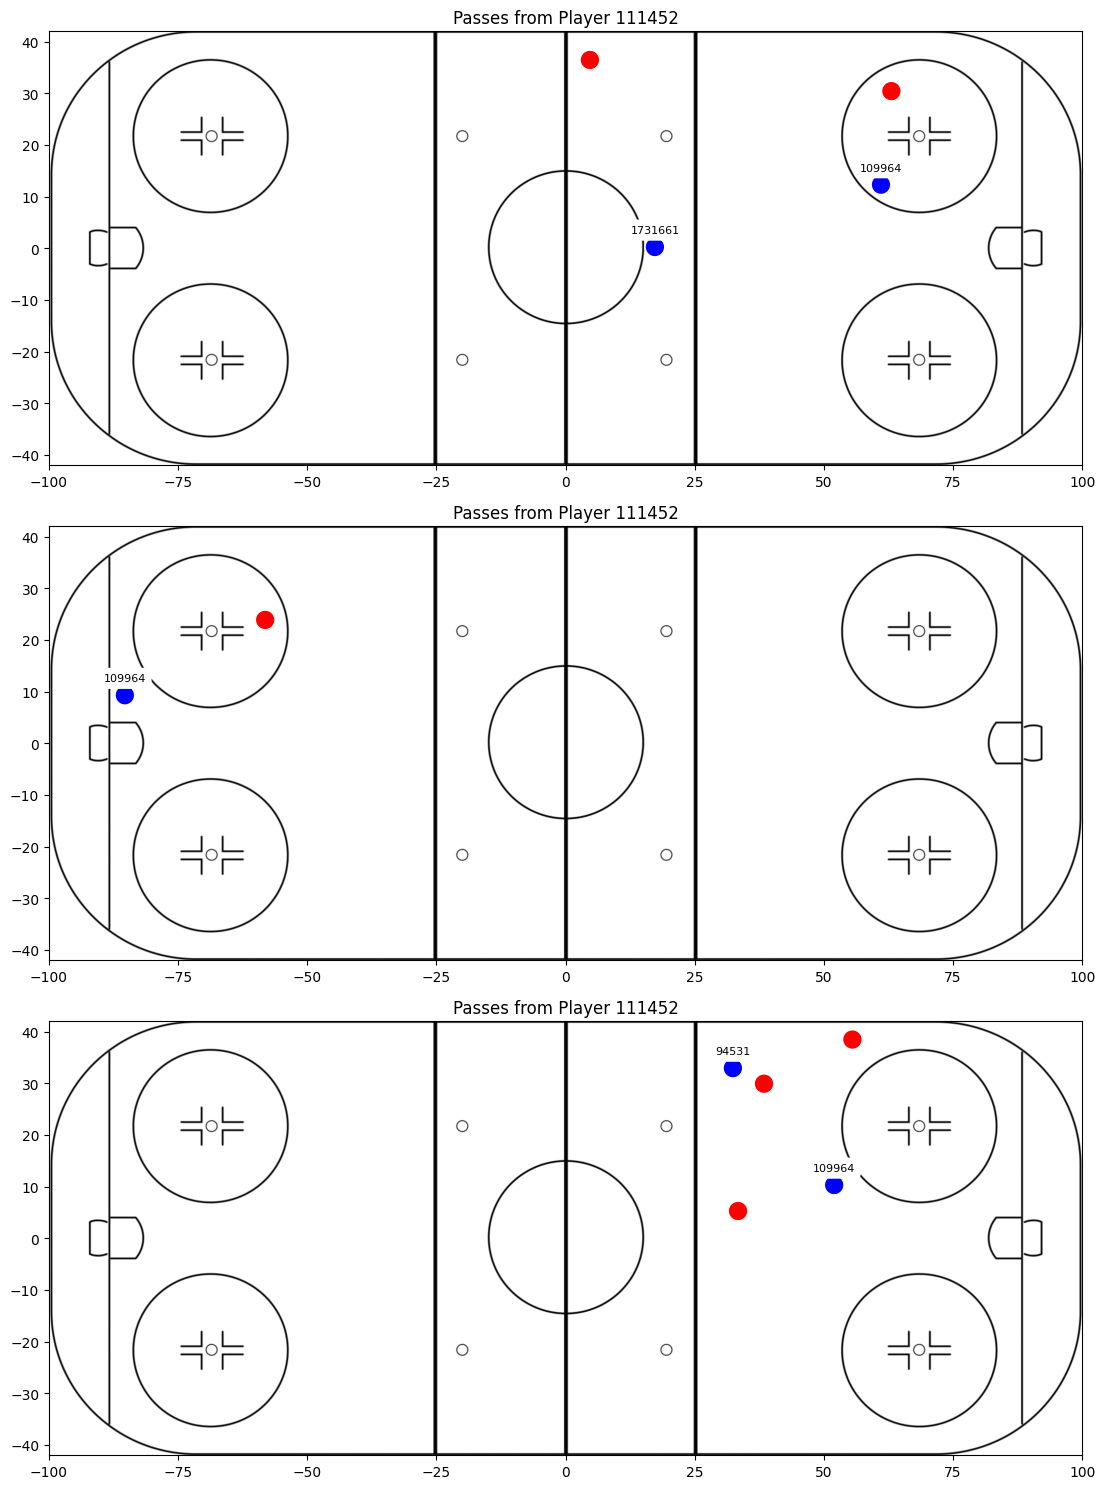

In [63]:

fig, axs = plt.subplots(3, 1, figsize=(15, 15)) 


periods = [1, 2, 3]
titles = ["Period 1", "Period 2", "Period 3"]

for ax, period, title in zip(axs, periods, titles):

    period_data = player_sequences1[player_sequences1['period'] == period]
    

    ax.imshow(img, extent=[-100, 100, -42, 42])
    

    period_data['color'] = 'blue'  
    period_data.loc[period_data['playerid'] == 111452, 'color'] = 'red'


    ax.scatter(period_data['ovixCoords'], period_data['oviyCoords'],
               s=200, c=period_data['color'], edgecolor="white")

    for idx, row in period_data[period_data['color'] == 'blue'].iterrows():
        ax.annotate(row['playerid'], 
                    (row['ovixCoords'], row['oviyCoords']),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center',
                    fontsize=8,
                    color='black',
                    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.5'))
    
    

    ax.set_xlim(-100, 100)
    ax.set_ylim(-42, 42)
    ax.set_title(f"Passes from Player 111452")
    

plt.tight_layout() 
plt.show()

In [64]:
player_sequences2 = shot_assists
player_sequences2=player_sequences2[['eventname', 'period', 'playerid', 'ovixCoords','oviyCoords', 'compiledgametime', 'teamid','shot_assist']]
player_sequences2

,eventname,period,playerid,ovixCoords,oviyCoords,compiledgametime,teamid,shot_assist
0,pass,1,111452,2.316772,9.808823,0.733333,311,False
1,reception,1,80,26.457947,6.791176,1.333333,311,False
2,pass,1,80,30.481476,30.932352,2.566667,311,False
3,reception,1,111452,3.718521,35.458824,3.166667,311,False
4,pass,1,80264,81.171463,3.770588,5.433333,315,False
...,...,...,...,...,...,...,...,...
1792,pass,4,126723,-51.497932,40.488235,3835.400000,315,False
1793,reception,4,20775372,-32.386169,5.785294,3836.266600,315,False
1794,pass,4,20775372,-33.392052,-7.794117,3837.966600,315,True
1795,reception,4,81408,-62.051838,-26.402939,3838.733400,315,NaN


Question 5 part D - multiple shot attempts and avg time

In [65]:

time_differences = []


for idx, reception_row in shot_assists[shot_assists['eventname'] == 'reception'].iterrows():
    reception_time = reception_row['compiledgametime']
    reception_period = reception_row['period']
    reception_player = reception_row['playerid']
    reception_team = reception_row['teamid']
    

    following_events = shot_assists[(shot_assists['period'] == reception_period) & 
                                    (shot_assists['compiledgametime'] > reception_time)]
    following_shots = following_events[following_events['eventname'] == 'shot']
    
    if not following_shots.empty:

        shot_row = following_shots.iloc[0]
        shot_time = shot_row['compiledgametime']
        shot_scored = shot_row['goal']
        shot_assisted = shot_row['shot_assist']
        shot_manpower = shot_row['manpowersituation']
        

        if shot_row['playerid'] == reception_player and shot_row['teamid'] == reception_team:
            time_diff = (shot_time - reception_time)
            time_differences.append({
                'playerid': reception_player,
                'period': reception_period,
                'reception_time': reception_time,
                'shot_time': shot_time,
                'time_diff_seconds': time_diff,
                'goal_scored': shot_scored,
                'shot_assisted':shot_assisted,
                'manpower': shot_manpower
            })


shot_time = pd.DataFrame(time_differences)


shot_counts = shot_time['playerid'].value_counts()


multi_shot_players = shot_counts[shot_counts > 1].index
all_shot_players = shot_time

multi_shots = shot_time[shot_time['playerid'].isin(multi_shot_players)]


multi_shots

,playerid,period,reception_time,shot_time,time_diff_seconds,goal_scored,shot_assisted,manpower
0,94531,1,30.633333,30.733334,0.100001,0,False,evenStrength
1,109964,1,38.400000,38.633335,0.233335,1,False,evenStrength
3,109964,1,130.400000,131.700000,1.300000,0,False,evenStrength
4,20775372,1,145.200000,146.366670,1.166670,0,False,evenStrength
5,20775372,1,167.900000,186.566670,18.666670,0,False,evenStrength
...,...,...,...,...,...,...,...,...
148,81408,4,3741.266600,3742.100000,0.833400,0,False,powerPlay
149,81408,4,3745.300000,3821.433300,76.133300,0,False,powerPlay
150,81408,4,3821.400000,3821.433300,0.033300,0,False,powerPlay
151,81408,4,3829.266600,3829.300000,0.033400,0,False,powerPlay


In [66]:
multi_shot_times = shot_time.groupby('playerid')['time_diff_seconds'].mean()
print(multi_shot_times.max())
print(multi_shot_times.idxmax())

19.073295999999754
126723


Question 6 part A all strengths xG battle

In [67]:
battle_data = pd.merge(event_data, xG_data, on=['compiledgametime', 'playerid'], how='inner')
battle_data.head()

,eventname,outcome,type,compiledgametime,playsection,zone,manpowersituation,goal,teamid,playerid,opposingteamgoalieoniceid,xadjcoord,yadjcoord,minutes,period,xCoord,yCoord,xg
0,shot,failed,outsideblocked,30.733334,westPoint,oz,evenStrength,0,311,94531,80264,30.869484,-36.964706,0.51,1,-30.869484,-36.964706,0.002939
1,shot,successful,outside,38.633335,outsideNorthWest,oz,evenStrength,1,311,109964,80264,80.157722,-13.326469,0.64,1,-80.157722,-13.326469,0.072824
2,shot,failed,outside,79.433334,outsideNorthEast,oz,evenStrength,0,315,884,5152,81.278534,22.379410,1.32,1,81.278534,22.379410,0.037817
3,pass,failed,north,82.200000,westPoint,oz,evenStrength,0,315,56711,5152,40.037399,-38.476501,1.37,1,40.037399,-38.476501,0.252678
4,pass,successful,outlet,90.900000,outsideNorthWestDZ,dz,evenStrength,0,311,108339,80264,-87.321686,32.441177,1.52,1,-87.321686,32.441177,0.392448


In [68]:
#summing up the xg
battle_data = battle_data.groupby('teamid')['xg'].sum()
battle_data = pd.DataFrame(battle_data).reset_index()
battle_data

,teamid,xg
0,311,5.153972
1,315,4.099661


Question 7 exploration

In [69]:
#creating a dataframe with some variables I would like to explore as features for xG prediction

model_df = pd.merge(event_data, xG_data, on=['compiledgametime', 'playerid'], how='inner')
#If it is the case that the player is Ovi, to ensure that the y coordinates are properly unfolded:

def reverse_adjust_coordinates(row):
    x_adjusted = row['xadjcoord']
    y_adjusted = row['yadjcoord']
    
    team_id = row['teamid']  
    period = row['period'] 
            
    if period in [1,3]:
        if x_adjusted < 0:
            original_x = abs(x_adjusted) #if adjusted is negative, make it positive
            original_y = abs(y_adjusted)
        else:
            original_x = x_adjusted #if adjusted is positive, use it
            original_y = abs(y_adjusted)
    else:#2nd period and OT
        if x_adjusted <0:
            original_x = x_adjusted #if adjusted is negative, use it
            original_y = y_adjusted
        else:
            original_x = -x_adjusted #if adjusted is positive , make it negative
            original_y = y_adjusted
    
    return pd.Series({'ovixCoords': original_x, 'oviyCoords': original_y})


original_coords = model_df.apply(reverse_adjust_coordinates, axis=1)


model_df = model_df.join(original_coords)

#create distance calculation for each event
#center net
net_x = 89
net_y = 0

def calculate_distance(x, y, net_x=net_x, net_y=net_y):
    return math.sqrt((x - net_x)**2 + (y - net_y)**2)


model_df['distance'] = model_df.apply(lambda row: calculate_distance(row['ovixCoords'], row['oviyCoords']), axis=1)


In [70]:
model_df=model_df[['goal','distance', 'manpowersituation', 'playsection','outcome','zone','period']]
model_df['period']= model_df['period'].astype(str)
model_df.head()

,goal,distance,manpowersituation,playsection,outcome,zone,period
0,0,68.887926,evenStrength,westPoint,failed,oz,1
1,1,15.993144,evenStrength,outsideNorthWest,successful,oz,1
2,0,23.674016,evenStrength,outsideNorthEast,failed,oz,1
3,0,62.271803,evenStrength,westPoint,failed,oz,1
4,0,32.484561,evenStrength,outsideNorthWestDZ,successful,dz,1


At first I thought about trying this ANOVA regression, but the adjusted R-squared value was showing it was not a great fit.

In [71]:
formula = 'goal ~ distance + manpowersituation + playsection + outcome + zone + period'
model = smf.ols(formula=formula, data=model_df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   goal   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.9257
Date:                Thu, 05 Sep 2024   Prob (F-statistic):              0.559
Time:                        09:37:31   Log-Likelihood:                 20.872
No. Observations:                 132   AIC:                             2.256
Df Residuals:                     110   BIC:                             65.68
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [72]:
## Define the coefficients
Intercept =  0.0401
powerPlay = -0.0401      
shortHanded = -0.0929             
eastOuterSlot = -0.0224  
eastPoint = -0.0678 
eastPointDZ = -0.0253   
innerSlot =  0.0366           
northCenterNZ = -0.1515
northEastBoardsNZ = -0.0270           
outsideNorthEast =  -0.0576  
outsideNorthEastDZ =-0.1056
outsideNorthWest = 0.1018
outsideNorthWestDZ =  -0.1054 
westOuterSlot = -0.0237
westOuterSlotDZ = -0.1321
westPoint =   -0.0555 
successful =  0.1259
oz = 0.0742  
period2 = 0.1629
period3= - 0.0548 
period4 =  0.2051
distance = -0.0017  




In [73]:
dummy_df = model_df[['manpowersituation', 'playsection', 'outcome','zone','period']]
dummies = pd.get_dummies(dummy_df,dtype=int)

model_df = pd.concat([model_df, dummies], axis=1)

model_df = model_df.drop(['outcome', 'manpowersituation','playsection','zone','period'], axis=1)

model_df

,goal,distance,manpowersituation_evenStrength,manpowersituation_powerPlay,manpowersituation_shortHanded,playsection_centerPoint,playsection_eastOuterSlot,playsection_eastPoint,playsection_eastPointDZ,playsection_innerSlot,...,playsection_westOuterSlotDZ,playsection_westPoint,outcome_failed,outcome_successful,zone_dz,zone_oz,period_1,period_2,period_3,period_4
0,0,68.887926,1,0,0,0,0,0,0,0,...,0,1,1,0,0,1,1,0,0,0
1,1,15.993144,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0
2,0,23.674016,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0
3,0,62.271803,1,0,0,0,0,0,0,0,...,0,1,1,0,0,1,1,0,0,0
4,0,32.484561,1,0,0,0,0,0,0,0,...,0,0,0,1,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,0,152.627697,0,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
128,0,132.882242,0,1,0,0,0,0,0,0,...,0,1,1,0,0,1,0,0,0,1
129,0,151.142461,0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
130,0,149.934836,0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1


In [74]:
model_df['Predicted_Goals'] = (
    Intercept +
    (powerPlay * model_df['manpowersituation_powerPlay']) +
    (shortHanded * model_df['manpowersituation_shortHanded']) +
    (eastOuterSlot * model_df['playsection_eastOuterSlot']) +
    (eastPoint * model_df['playsection_eastPoint']) +
    (eastPointDZ * model_df['playsection_eastPointDZ']) +
    (innerSlot * model_df['playsection_innerSlot']) +
    (northEastBoardsNZ * model_df['playsection_northEastBoardsNZ']) +
    (northCenterNZ * model_df['playsection_northCenterNZ']) +
    (outsideNorthEast * model_df['playsection_outsideNorthEast']) +
    (outsideNorthEastDZ * model_df['playsection_outsideNorthEastDZ']) +
    (outsideNorthWest * model_df['playsection_outsideNorthWest']) +
    (outsideNorthWestDZ * model_df['playsection_outsideNorthWestDZ']) +
    (westOuterSlot * model_df['playsection_westOuterSlot'])+
    (westOuterSlotDZ * model_df['playsection_westOuterSlotDZ']) +
    (westPoint * model_df['playsection_westPoint']) +
    (successful * model_df['outcome_successful']) +
    (oz * model_df['zone_oz'])+
    (distance * model_df['distance']) +
    (period2 * model_df['period_2'])+
    (period3 * model_df['period_3']) +
    (period4 * model_df['period_4'])
    )


model_df['Predicted_Goals'] = round(model_df['Predicted_Goals'],2)
model_df

,goal,distance,manpowersituation_evenStrength,manpowersituation_powerPlay,manpowersituation_shortHanded,playsection_centerPoint,playsection_eastOuterSlot,playsection_eastPoint,playsection_eastPointDZ,playsection_innerSlot,...,playsection_westPoint,outcome_failed,outcome_successful,zone_dz,zone_oz,period_1,period_2,period_3,period_4,Predicted_Goals
0,0,68.887926,1,0,0,0,0,0,0,0,...,1,1,0,0,1,1,0,0,0,-0.06
1,1,15.993144,1,0,0,0,0,0,0,0,...,0,0,1,0,1,1,0,0,0,0.31
2,0,23.674016,1,0,0,0,0,0,0,0,...,0,1,0,0,1,1,0,0,0,0.02
3,0,62.271803,1,0,0,0,0,0,0,0,...,1,1,0,0,1,1,0,0,0,-0.05
4,0,32.484561,1,0,0,0,0,0,0,0,...,0,0,1,1,0,1,0,0,0,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,0,152.627697,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0.25
128,0,132.882242,0,1,0,0,0,0,0,0,...,1,1,0,0,1,0,0,0,1,-0.00
129,0,151.142461,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,-0.00
130,0,149.934836,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0.00


I pivoted and opted to use time, shot assists, playerid, period, and time as part of a random forest 

In [75]:
dummy_df = all_shot_players[['manpower']]
dummies = pd.get_dummies(dummy_df,dtype=int)

all_shot_players = pd.concat([all_shot_players, dummies], axis=1)


all_shot_players


,playerid,period,reception_time,shot_time,time_diff_seconds,goal_scored,shot_assisted,manpower,manpower_evenStrength,manpower_powerPlay
0,94531,1,30.633333,30.733334,0.100001,0,False,evenStrength,1,0
1,109964,1,38.400000,38.633335,0.233335,1,False,evenStrength,1,0
2,1462,1,109.100000,111.133330,2.033330,0,False,evenStrength,1,0
3,109964,1,130.400000,131.700000,1.300000,0,False,evenStrength,1,0
4,20775372,1,145.200000,146.366670,1.166670,0,False,evenStrength,1,0
...,...,...,...,...,...,...,...,...,...,...
148,81408,4,3741.266600,3742.100000,0.833400,0,False,powerPlay,0,1
149,81408,4,3745.300000,3821.433300,76.133300,0,False,powerPlay,0,1
150,81408,4,3821.400000,3821.433300,0.033300,0,False,powerPlay,0,1
151,81408,4,3829.266600,3829.300000,0.033400,0,False,powerPlay,0,1


In [76]:
all_shot_players.head()

,playerid,period,reception_time,shot_time,time_diff_seconds,goal_scored,shot_assisted,manpower,manpower_evenStrength,manpower_powerPlay
0,94531,1,30.633333,30.733334,0.100001,0,False,evenStrength,1,0
1,109964,1,38.400000,38.633335,0.233335,1,False,evenStrength,1,0
2,1462,1,109.100000,111.133330,2.033330,0,False,evenStrength,1,0
3,109964,1,130.400000,131.700000,1.300000,0,False,evenStrength,1,0
4,20775372,1,145.200000,146.366670,1.166670,0,False,evenStrength,1,0


In [77]:

features = all_shot_players[['playerid', 'period', 'reception_time', 'shot_time',
       'time_diff_seconds','shot_assisted',
       'manpower_evenStrength', 'manpower_powerPlay']]
target = all_shot_players['goal_scored']
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [78]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)


In [79]:
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [80]:
y_pred = model.predict(X_test)
y_pred

array([0.  , 0.01, 0.  , 0.  , 0.02, 0.01, 0.  , 0.04, 0.03, 0.09, 0.1 ,
       0.  , 0.05, 0.  , 0.01, 0.08, 0.1 , 0.  , 0.05, 0.43, 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.07, 0.  , 0.08, 0.01])

Here the squared difference is small, showing reasonably good model performance. The R^2 of 0.6084 shows a decent fit, too.

In [81]:


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')


Mean Squared Error: 0.012225806451612907
R^2 Score: 0.6083666666666667


Feature importance: time differene between reception and shot is the most significant predictor here. Next is essentially time - when the events happen in a game. Third is the player.

In [82]:

# Feature importance
importances = model.feature_importances_
feature_names = features.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print(importance_df.sort_values(by='Importance', ascending=False))

                 Feature  Importance
4      time_diff_seconds    0.348448
2         reception_time    0.231228
3              shot_time    0.205231
0               playerid    0.110960
1                 period    0.040022
5          shot_assisted    0.027941
7     manpower_powerPlay    0.022394
6  manpower_evenStrength    0.013776


Some refining fo better utilize these features

In [83]:
all_shot_players['reception_shot_interaction'] = all_shot_players['reception_time'] * all_shot_players['shot_time']
all_shot_players['time_diff_reception_interaction'] = all_shot_players['time_diff_seconds'] * all_shot_players['reception_time']
all_shot_players.head()

,playerid,period,reception_time,shot_time,time_diff_seconds,goal_scored,shot_assisted,manpower,manpower_evenStrength,manpower_powerPlay,reception_shot_interaction,time_diff_reception_interaction
0,94531,1,30.633333,30.733334,0.100001,0,False,evenStrength,1,0,941.464455,3.063364
1,109964,1,38.400000,38.633335,0.233335,1,False,evenStrength,1,0,1483.520064,8.960064
2,1462,1,109.100000,111.133330,2.033330,0,False,evenStrength,1,0,12124.646303,221.836303
3,109964,1,130.400000,131.700000,1.300000,0,False,evenStrength,1,0,17173.680000,169.520000
4,20775372,1,145.200000,146.366670,1.166670,0,False,evenStrength,1,0,21252.440484,169.400484


In [84]:
all_shot_players['time_bucket'] = pd.cut(all_shot_players['shot_time'], bins=[0, 20, 40, 60], labels=['Early', 'Mid', 'Late'])
all_shot_players.head()

,playerid,period,reception_time,shot_time,time_diff_seconds,goal_scored,shot_assisted,manpower,manpower_evenStrength,manpower_powerPlay,reception_shot_interaction,time_diff_reception_interaction,time_bucket
0,94531,1,30.633333,30.733334,0.100001,0,False,evenStrength,1,0,941.464455,3.063364,Mid
1,109964,1,38.400000,38.633335,0.233335,1,False,evenStrength,1,0,1483.520064,8.960064,Mid
2,1462,1,109.100000,111.133330,2.033330,0,False,evenStrength,1,0,12124.646303,221.836303,NaN
3,109964,1,130.400000,131.700000,1.300000,0,False,evenStrength,1,0,17173.680000,169.520000,NaN
4,20775372,1,145.200000,146.366670,1.166670,0,False,evenStrength,1,0,21252.440484,169.400484,NaN


Cross validation

In [85]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Example data
X = all_shot_players[['time_diff_seconds', 'reception_time', 'shot_time']]
y = all_shot_players['goal_scored']  # Replace with your target variable

# Initialize the model
model = RandomForestRegressor()

# Perform K-Fold Cross-Validation
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')  # cv=5 means 5 folds
mean_score = np.mean(scores)
print(f'Mean Negative MSE from Cross-Validation: {mean_score}')


Mean Negative MSE from Cross-Validation: -0.08470303225806451
